# PROBLEM SET 3: LOGISTIC REGRESSION

### SEAN XANDER B. AQUINO | BSCS 2A

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from ucimlrepo import fetch_ucirepo

In [103]:
# Fetch and prepare data
dataset = fetch_ucirepo(id=14) 
X = dataset.data.features 
y = dataset.data.targets 

# Displaying basic information about the dataset


In [ ]:
print("Dataset Shape:", X.shape)
print("\nFeature Names:\n", X.columns.tolist())
print("\nSample Data:")
print(X.head())
print("\nTarget Distribution:")
print(y['Class'].value_counts())

Dataset Shape: (286, 9)

Feature Names:
 ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat']

Sample Data:
     age menopause tumor-size inv-nodes node-caps  deg-malig breast  \
0  30-39   premeno      30-34       0-2        no          3   left   
1  40-49   premeno      20-24       0-2        no          2  right   
2  40-49   premeno      20-24       0-2        no          2   left   
3  60-69      ge40      15-19       0-2        no          2  right   
4  40-49   premeno        0-4       0-2        no          2  right   

  breast-quad irradiat  
0    left_low       no  
1    right_up       no  
2    left_low       no  
3     left_up       no  
4   right_low       no  

Target Distribution:
Class
no-recurrence-events    201
recurrence-events        85
Name: count, dtype: int64


In [106]:
# Convert target to binary (0 for no-recurrence-events, 1 for recurrence-events)
y = (y['Class'] == 'recurrence-events').astype(int)

In [107]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (228, 9)
Testing set shape: (58, 9)


In [108]:
# Define categorical columns
categorical_columns = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 
                      'breast', 'breast-quad', 'irradiat']

### Apply One-Hot Encoding to handles unseen categories


In [109]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

c:\Users\Sean Xander Aquino\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [110]:
X_train_encoded = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
X_test_encoded = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

In [111]:
X_train = X_train.drop(columns=categorical_columns).reset_index(drop=True)
X_test = X_test.drop(columns=categorical_columns).reset_index(drop=True)

X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded], axis=1)

# Feature scaling

In [112]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Convert to DataFrame to maintain column names


In [113]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Training the Logistic Regression model


In [114]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=1000, random_state=42)

### Getting the predicted probabilities


In [115]:
y_probs = model.predict_proba(X_test_scaled)[:, 1]

### Create a DataFrame for plotting


In [116]:
example_df = X_test.copy()
example_df['target'] = y_test.values
example_df['logistic_preds'] = y_probs

In [ ]:
if 'tumor-size' in example_df.columns: # example feature
    feature_name = 'tumor-size'
else:
    feature_name = example_df.columns[0]

# Convert tumor size to numeric if needed
example_df[feature_name] = pd.to_numeric(example_df[feature_name], errors='coerce')

# Drop NaN values that may have been introduced
example_df = example_df.dropna(subset=[feature_name])

## Visualization of 

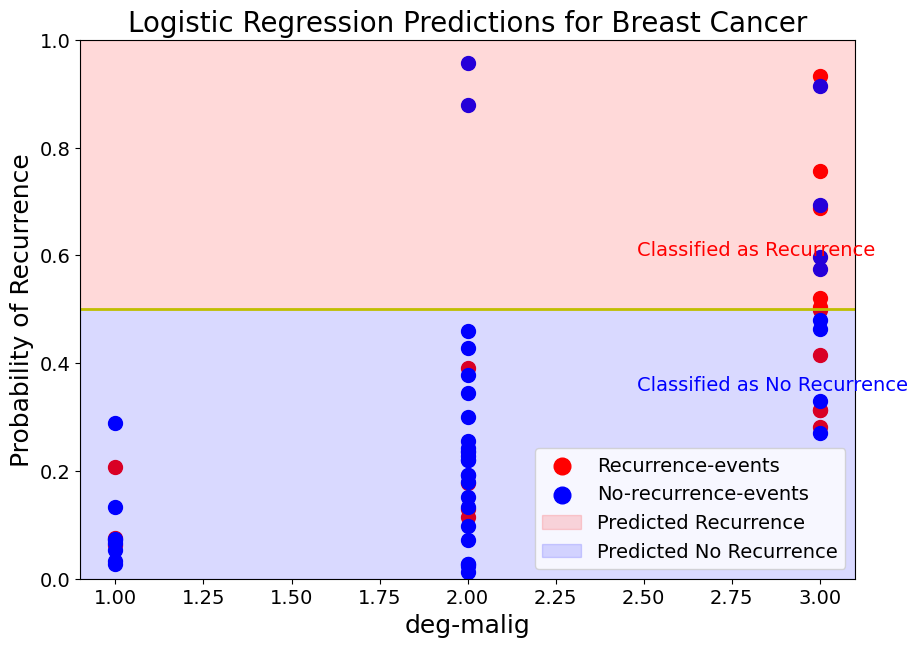

In [118]:
fig, ax = plt.subplots(figsize=(10, 7))

# Define filters for target classes
recurrenceFilter = example_df['target'] == 1  # Recurrence-events
noRecurrenceFilter = example_df['target'] == 0  # No-recurrence-events

# Scatter plot for each class
ax.scatter(example_df.loc[recurrenceFilter, feature_name].values,
           example_df.loc[recurrenceFilter, 'logistic_preds'].values,
           color='r', 
           s=100, 
           label='Recurrence-events')

ax.scatter(example_df.loc[noRecurrenceFilter, feature_name].values,
           example_df.loc[noRecurrenceFilter, 'logistic_preds'].values,
           color='b',  
           s=100, 
           label='No-recurrence-events')

ax.axhline(y=0.5, c='y', linewidth=2)

ax.axhspan(0.5, 1, alpha=0.15, color='red', label="Predicted Recurrence")
ax.axhspan(0, 0.5, alpha=0.15, color='blue', label="Predicted No Recurrence")

ax.text(ax.get_xlim()[1] * 0.8, 0.6, 'Classified as Recurrence', fontsize=14, color='red')
ax.text(ax.get_xlim()[1] * 0.8, 0.35, 'Classified as No Recurrence', fontsize=14, color='blue')

ax.set_ylim(0, 1)
ax.set_xlabel(feature_name, fontsize=18)
ax.set_ylabel('Probability of Recurrence', fontsize=18)
ax.set_title('Logistic Regression Predictions for Breast Cancer', fontsize=20)
ax.legend(loc='lower right', markerscale=1.2, fontsize=14)
ax.tick_params(labelsize=14)

plt.show()


# Displaying the correlation matrix for encoded features

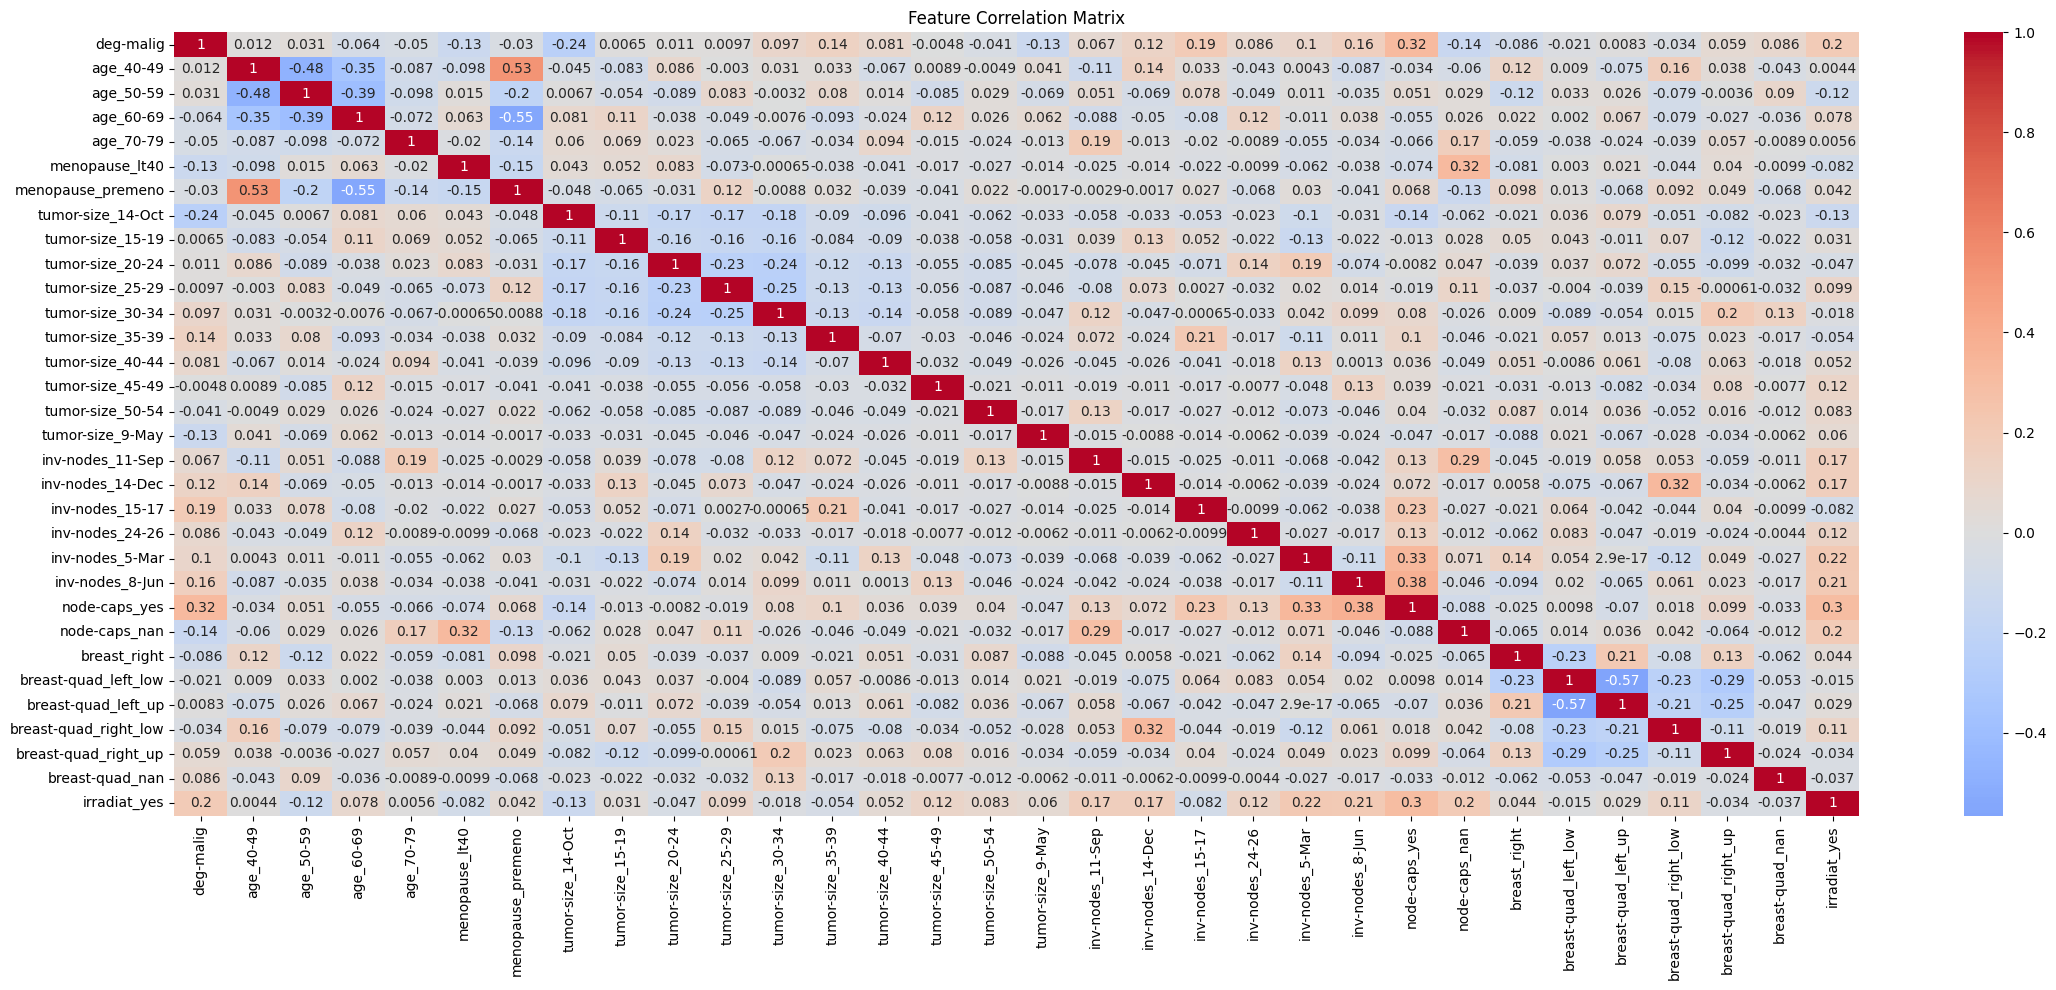

In [119]:
plt.figure(figsize=(23, 10))
sns.heatmap(X_train_scaled.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [120]:
print("\nPreprocessing Summary:")
print("-" * 50)
print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Features processed: {len(categorical_columns)}")
print(f"Target distribution in training set:\n{pd.Series(y_train).value_counts()}")


Preprocessing Summary:
--------------------------------------------------
Total samples: 286
Training samples: 228
Testing samples: 58
Features processed: 8
Target distribution in training set:
Class
0    160
1     68
Name: count, dtype: int64


## Displaying first few rows of processed data


In [121]:
print("\nFirst few rows of processed training data:")
print(X_train_scaled.head())


First few rows of processed training data:
   deg-malig  age_40-49  age_50-59  age_60-69  age_70-79  menopause_lt40  \
0  -0.041171    1.53393  -0.735215  -0.536783  -0.133631       -0.149738   
1  -0.041171   -0.65192  -0.735215   1.862951  -0.133631       -0.149738   
2  -0.041171   -0.65192   1.360147  -0.536783  -0.133631       -0.149738   
3  -0.041171    1.53393  -0.735215  -0.536783  -0.133631       -0.149738   
4   1.299843   -0.65192  -0.735215   1.862951  -0.133631       -0.149738   

   menopause_premeno  tumor-size_14-Oct  tumor-size_15-19  tumor-size_20-24  \
0          -1.017700          -0.350931         -0.326797          2.104417   
1          -1.017700          -0.350931         -0.326797         -0.475191   
2           0.982607          -0.350931         -0.326797         -0.475191   
3           0.982607          -0.350931         -0.326797         -0.475191   
4          -1.017700          -0.350931         -0.326797         -0.475191   

   ...  inv-nodes_8-Jun 

# Getting the model's accuracy


Model Accuracy: 0.6896551724137931

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.80        41
           1       0.45      0.29      0.36        17

    accuracy                           0.69        58
   macro avg       0.60      0.57      0.58        58
weighted avg       0.66      0.69      0.67        58



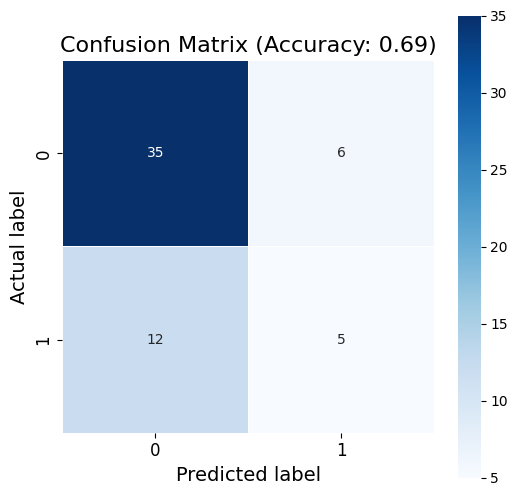

In [ ]:
score = model.score(X_test_scaled, y_test)
print("Model Accuracy:", score)

cm = metrics.confusion_matrix(y_test, model.predict(X_test_scaled))

print("\nClassification Report:")
print(metrics.classification_report(y_test, model.predict(X_test_scaled)))

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')

plt.ylabel('Actual label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.title(f'Confusion Matrix (Accuracy: {score:.2f})', fontsize=16)
plt.tick_params(labelsize=12)
plt.show()


# Training the model using regularizations [L1 (Lasso) and L2 (Ridge)]
### to determine the effects of using regularization in training a model



Original Model Accuracy: 0.6896551724137931
L1 Regularized Model Accuracy: 0.6724137931034483
L2 Regularized Model Accuracy: 0.6896551724137931


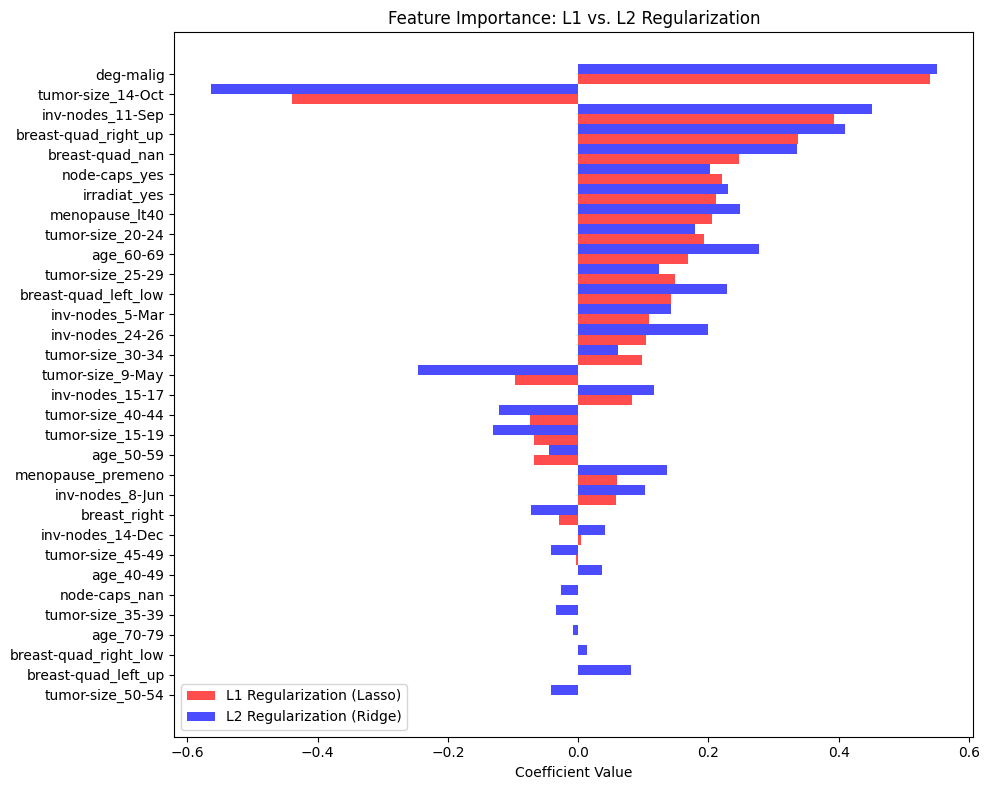

In [ ]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

model_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
model_l1.fit(X_train_scaled, y_train)

model_l2 = LogisticRegression(penalty='l2', solver='lbfgs', random_state=42, max_iter=1000)
model_l2.fit(X_train_scaled, y_train)

score_original = model.score(X_test_scaled, y_test)
score_l1 = model_l1.score(X_test_scaled, y_test)
score_l2 = model_l2.score(X_test_scaled, y_test)

print("\nOriginal Model Accuracy:", score_original)
print("L1 Regularized Model Accuracy:", score_l1)
print("L2 Regularized Model Accuracy:", score_l2)

coef_l1 = model_l1.coef_[0]
coef_l2 = model_l2.coef_[0]

features = X_train.columns

sorted_indices = np.argsort(np.abs(coef_l1))

features_sorted = [features[i] for i in sorted_indices]
coef_l1_sorted = [coef_l1[i] for i in sorted_indices]
coef_l2_sorted = [coef_l2[i] for i in sorted_indices]

fig, ax = plt.subplots(figsize=(10, 8))

bar_height = 0.50

ax.barh(np.arange(len(features)), coef_l1_sorted, height=bar_height, label="L1 Regularization (Lasso)", color='red', alpha=0.7)
ax.barh(np.arange(len(features)) + bar_height, coef_l2_sorted, height=bar_height, label="L2 Regularization (Ridge)", color='blue', alpha=0.7)

ax.set_yticks(np.arange(len(features)) + bar_height / 2)
ax.set_yticklabels(features_sorted)
ax.set_xlabel("Coefficient Value")
ax.set_title("Feature Importance: L1 vs. L2 Regularization")
ax.legend()

plt.tight_layout()
plt.show()
